<a href="https://colab.research.google.com/github/regulate-tech/nhstech/blob/main/subject-paper/nhstech_project_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NHS tech paper on cost of storing paper medical records

GOAL: create a dataset we can use to analyse spending on storing paper medical records in the NHS.

CONTEXT:  
- The NHS has committed to replacing paper medical records with digital records several times but this has not happened.
- One way to understand the gap between commitment and delivery is to look at spending on storing and using paper records.
- All NHS Trusts have to complete an annual return for their estate costs which includes data on paper records costs - this is called [the ERIC return](https://digital.nhs.uk/data-and-information/publications/statistical/estates-returns-information-collection).

In [167]:
import os
import re
from urllib.parse import unquote, urlparse

import chardet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

First, fetch all the CSV files from the [published ERIC collection](https://digital.nhs.uk/data-and-information/publications/statistical/estates-returns-information-collection) and store them in a local directory. As there are relatively few of these, we just store the links manually.

In [162]:
DATA_URLS = [
    # NB: The 2023/24 data here is provisional - update the top 3 links here when the final data is published.
    'https://files.digital.nhs.uk/8B/75875E/ERIC%20-%202023_24%20-%20Trust%20data%20-%20Provisional.csv',
    'https://files.digital.nhs.uk/AF/AC55EB/ERIC%20-%202023_24%20-%20Site%20data%20-%20Provisional.csv',
    'https://files.digital.nhs.uk/5D/147420/ERIC%20-%202023_24%20-%20PFI%20data%20-%20Provisional.csv',
    'https://files.digital.nhs.uk/FB/BE3AC8/ERIC%20-%20202223%20-%20Trust%20data.csv',
    'https://files.digital.nhs.uk/41/5787C9/ERIC%20-%202022_23%20-%20Site%20data.csv',
    'https://files.digital.nhs.uk/42/D5A005/ERIC%20-%202022_23%20-%20PFI%20data.csv',
    'https://files.digital.nhs.uk/08/84C46C/ERIC%20-%20202122%20-%20Trust%20data.csv',
    'https://files.digital.nhs.uk/EE/7E330D/ERIC%20-%20202122%20-%20Site%20Data%20v3.csv',
    'https://files.digital.nhs.uk/D3/D0DFD3/ERIC%20-%20202122%20-%20PFI%20data%20-%20v2.csv',
    'https://files.digital.nhs.uk/81/4A77B0/ERIC%20-%20202021%20-%20Trust%20data.csv',
    'https://files.digital.nhs.uk/0F/46F719/ERIC%20-%20202021%20-%20Site%20data%20v2.csv',
    'https://files.digital.nhs.uk/5F/4B00BC/ERIC%20-%20202021%20-%20PFI%20data.csv',
    'https://files.digital.nhs.uk/84/07227E/ERIC%20-%20201920%20-%20TrustData.csv',
    'https://files.digital.nhs.uk/11/BC1043/ERIC%20-%20201920%20-%20SiteData%20-%20v2.csv',
    'https://files.digital.nhs.uk/51/8C7C23/ERIC%20-%20201920%20-%20PFIData.csv',
    'https://files.digital.nhs.uk/83/4AF81B/ERIC%20-%20201819%20-%20TrustData%20v4.csv',
    'https://files.digital.nhs.uk/63/ADBFFF/ERIC%20-%20201819%20-%20SiteData%20v4.csv',
    'https://files.digital.nhs.uk/F6/791B8F/ERIC%20-%20201819%20-%20PFIData%20v3.csv',
    'https://files.digital.nhs.uk/1B/7C75CF/ERIC-201718-TrustData.csv',
    'https://files.digital.nhs.uk/A8/188D99/ERIC-201718-SiteData.csv',
    'https://files.digital.nhs.uk/09/928620/ERIC-201718-PFIData.csv'
]

# Fetch raw data 

Fetch files, formatting filenames consistently.

In [163]:
os.makedirs("csv_files", exist_ok=True)
for url in DATA_URLS:
    try:
        response = requests.get(url)
        response.raise_for_status()
        # Format filenames if necessary.
        filename = unquote(os.path.basename(urlparse(url).path))
        filename = filename.replace(" ", "-")
        if "_" in filename:
            parts = filename.split("_")
            filename = parts[0] + parts[1]
        with open(os.path.join("csv_files", filename), 'wb') as f:
            f.write(response.content)
    except Exception as e:
        print(f"Failed to download {url}: {e}")

Make everything UTF-8, to avoid confusing pandas later.

In [168]:
csv_files = [f for f in os.listdir('csv_files') if f.endswith('.csv')]
for filename in csv_files:
  filepath = os.path.join('csv_files', filename)
  with open(filepath, 'rb') as f:
    rawdata = f.read()
  result = chardet.detect(rawdata)
  encoding = result["encoding"]
  if encoding != 'utf-8':
    try:
      with open(filepath, 'r', encoding=encoding) as f:
        data = f.read()
      with open(filepath, 'w', encoding='utf-8') as f:
        f.write(data)
      # print(f'{filename}: Converted from {encoding} to UTF-8')
    except Exception as e:
      print(f"Error converting {filename}: {e}")

# Extract MRC data points

The ERIC data has lots of data points in it, but in this exercise we just care about the use of paper records, so extract those columns.

In [165]:
def process_csv_files():
  """
  Opens CSV files that have 'Trust' in their filename,
  creates a dictionary with unique 'Trust Code' and 'Trust Name' pairings,
  extracts data from columns containing 'Medical Records', and stores it with the
  column name plus year code.
  """
  trust_data = {}

  # Get a list of all CSV files in the 'csv_files' directory that contain 'Trust'
  csv_files = [f for f in os.listdir('csv_files') if f.endswith('.csv') and "Trust" in f]
  for filename in csv_files:
    filepath = os.path.join('csv_files', filename)

    # Extract year from filename
    year_code = re.search(r'(\d{6})', filename)
    if year_code:
      year_code = year_code.group(1)
    else:
      year_code = "Unknown" 

    try:
      # This file has two superfluous header rows: skip them.
      if "202324---Trust-data---Provisional" in filepath:
        df = pd.read_csv(filepath, skiprows=2)
      else:
        df = pd.read_csv(filepath)
      df.head()

      if "Trust Code" in df.columns and "Trust Name" in df.columns:
        for index, row in df.iterrows():
          trust_code = row["Trust Code"]
          trust_name = row["Trust Name"]
          if (trust_code, trust_name) not in trust_data:
            trust_data[(trust_code, trust_name)] = {}
              
          for col in df.columns:
            if "Medical Records" in col:
              # Store the data with the column name plus year code
              trust_data[(trust_code, trust_name)][col + "_" + year_code] = row[col]

    except Exception as e:
      print(f"Error processing file {filename}: {e}")

  return trust_data

trust_data = process_csv_files()

# Convert to a DataFrame, reshape and simplify the column names.
trust_df = pd.DataFrame.from_dict(trust_data, orient='index')
trust_df = trust_df.reset_index()
trust_df = trust_df.rename(columns={'level_0': 'trust_code', 'level_1': 'trust_name'})
replacements = {
    r'Medical Records cost - Onsite \(£\)_(\d{6})': r'mrc_on_\1',
    r'Medical Records cost - Offsite \(£\)_(\d{6})': r'mrc_off_\1',
    r'Medical Records cost - Total \(£\)_(\d{6})': r'mrc_tot_\1',
    r'Medical Records volume - Onsite \(records\)_(\d{6})': r'mrv_on_\1',
    r'Medical Records volume - Offsite \(records\)_(\d{6})': r'mrv_off_\1',
    r'Medical Records volume - Total \(records\)_(\d{6})': r'mrv_tot_\1'
}
for old, new in replacements.items():
    trust_df.columns = trust_df.columns.str.replace(old, new, regex=True)

Now, create a summary table with 'Trust Code' and 'Trust Name' and each column starting 'mrc', in ascending year order. 

Save this to a new CSV file: this will be our reference data going forward.

In [166]:
# Select the desired columns, and create a new dataframe, sorted by year.
selected_columns = ['trust_code', 'trust_name'] + [col for col in trust_df.columns if col.startswith('mrc')]
filtered_df = trust_df[selected_columns]
filtered_df = filtered_df.reindex(sorted(filtered_df.columns, key=lambda x: x.split('_')[-1] if '_' in x else x), axis=1)

# Replace null values with 0; remove commas from the number columns, and convert to numbers.
number_columns = [col for col in filtered_df.columns if col not in ['trust_code', 'trust_name']]
number_columns.sort()
filtered_df[number_columns] = filtered_df[number_columns].apply(lambda x: x.str.replace(',', ''))
filtered_df[number_columns] = filtered_df[number_columns].apply(pd.to_numeric, errors='coerce')
filtered_df.fillna(0, inplace=True)

filtered_df.to_csv('trust_mrc_sorted_formatted.csv', index=False)
filtered_df.head(2)

,mrc_on_201718,mrc_off_201718,mrc_on_201819,mrc_off_201819,mrc_on_201920,mrc_off_201920,mrc_on_202021,mrc_off_202021,mrc_on_202122,mrc_off_202122,mrc_on_202223,mrc_off_202223,mrc_on_202324,mrc_off_202324,trust_code,trust_name
0,3612846.0,203096.0,2871339.0,145631.0,3285737.0,277200.0,3285787.0,458075.0,4875116.0,438847.0,5629069.0,296103.0,5557232.0,524104.0,R0A,MANCHESTER UNIVERSITY NHS FOUNDATION TRUST
1,155193.0,107682.0,169347.0,118345.0,184588.0,128996.0,201201.0,140606.0,0.0,0.0,0.0,0.0,0.0,0.0,R1A,WORCESTERSHIRE HEALTH AND CARE NHS TRUST


# Explore the data

We now have a `trust_mrc_sorted_formatted.csv` file, with the medical records cost by Trust and Year. We can present this data in different formats. 

In [155]:
def draw_chart(years, values_dict, title, xlabel, ylabel):
    '''Reusable utility chart function.'''
    plt.figure(figsize=(10, 6))
    
    x = np.arange(len(years))  # X-coordinates for the bars
    
    # Set up colors using matplotlib default color cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    # Initialize bottom positions for stacking
    bottoms = np.zeros(len(years))
    
    # Create bars and labels for each category
    for i, (category, values) in enumerate(values_dict.items()):
        plt.bar(x, values, bottom=bottoms, label=category, color=colors[i % len(colors)])
        
        # Add value labels in the middle of each bar segment
        for j, value in enumerate(values):
            if value > 0:  # Only add label if there's a visible bar
                # Calculate middle position of this segment
                middle_pos = bottoms[j] + value/2
                plt.text(j, middle_pos, f'£{value:,.0f}', 
                        ha='center', va='center')
        
        # Update bottoms for next category
        bottoms += np.array(values)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.ylim(bottom=0)
    plt.xticks(x, years)
    
    plt.legend()
    plt.show()

Now, create  barcharts for each of the first 5 trusts, showing their names and the annual spends on onsite and offsite records storage.

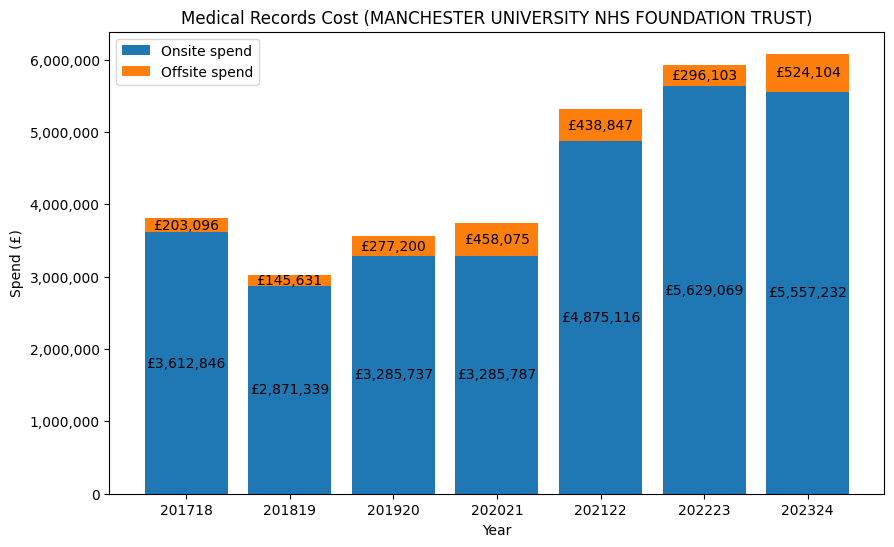

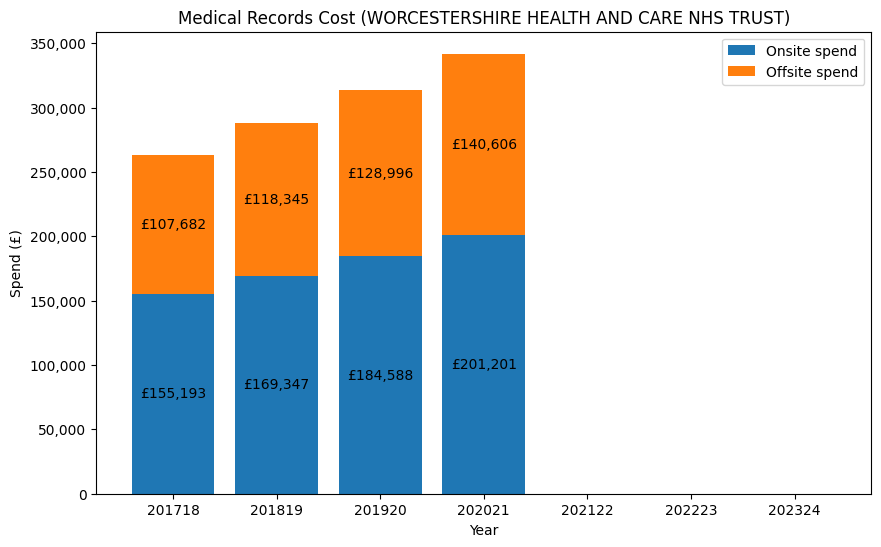

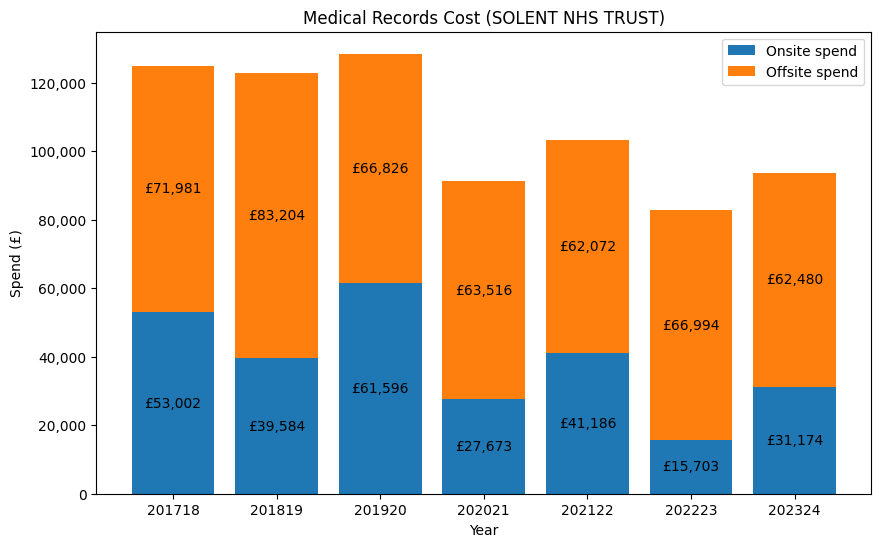

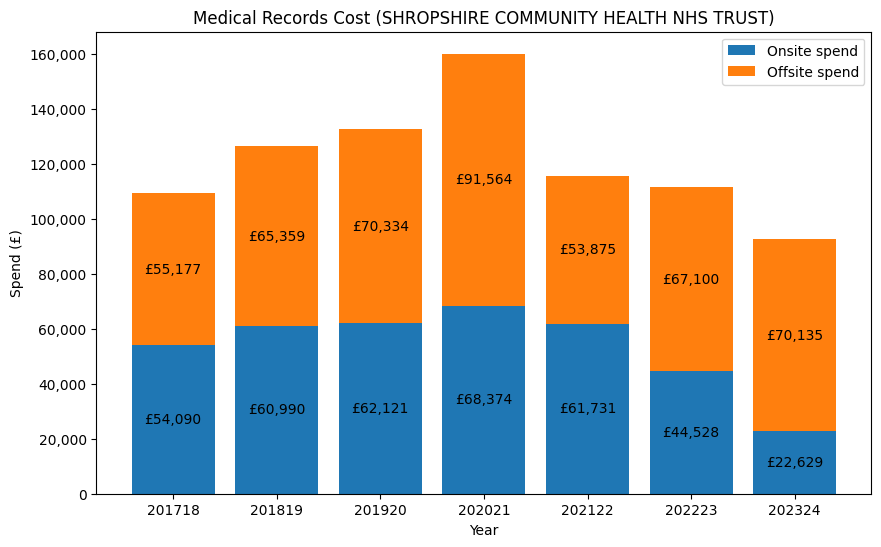

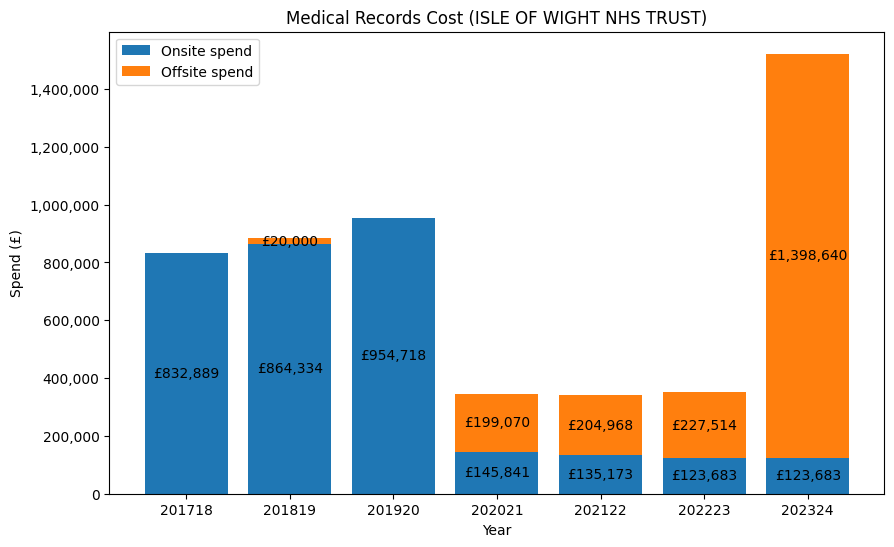

In [156]:
trust_df = pd.read_csv('trust_mrc_sorted_formatted.csv')

# Select the first 5 trusts
top_5_trusts = trust_df.head(5)
for index, row in top_5_trusts.iterrows():
  trust_name = row['trust_name']

  mrc_on_columns = [col for col in trust_df.columns if col.startswith('mrc_on')]
  mrc_off_columns = [col for col in trust_df.columns if col.startswith('mrc_off')]
  values_dict = {
      'Onsite spend': [row[col] for col in mrc_on_columns], 
      'Offsite spend': [row[col] for col in mrc_off_columns],
  }
  years = [col.split('_')[-1] for col in mrc_on_columns]
  draw_chart(years, values_dict, f'Medical Records Cost ({trust_name})', "Year", "Spend (£)")

### Chart total spending across all trusts

Now, chart the total spent on onsite records storage by year for all trusts...

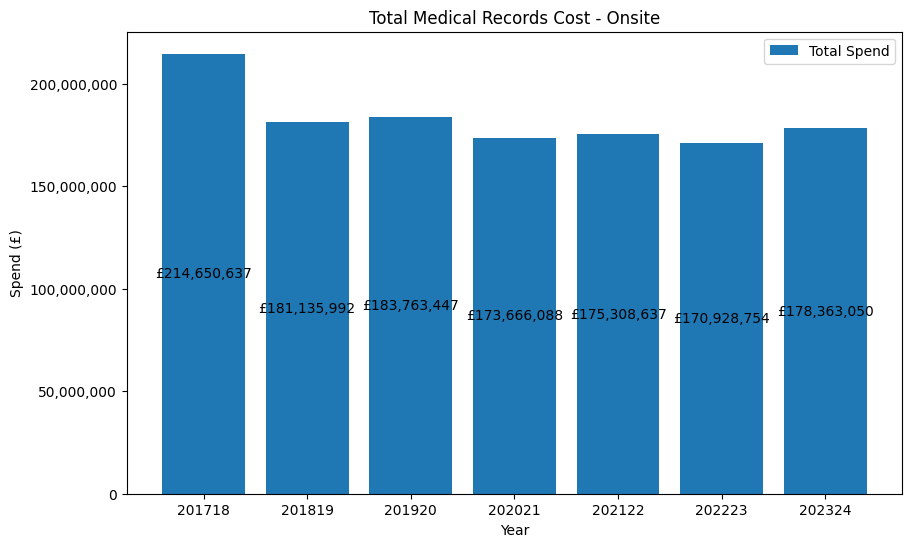

In [157]:
mrc_on_columns = [col for col in trust_df.columns if col.startswith('mrc_on')]
years = [col.split('_')[-1] for col in mrc_on_columns]
total_spend_by_year = trust_df[mrc_on_columns].sum()
draw_chart(years, {"Total Spend": total_spend_by_year}, f'Total Medical Records Cost - Onsite', "Year", "Spend (£)")

...and for offsite storage...

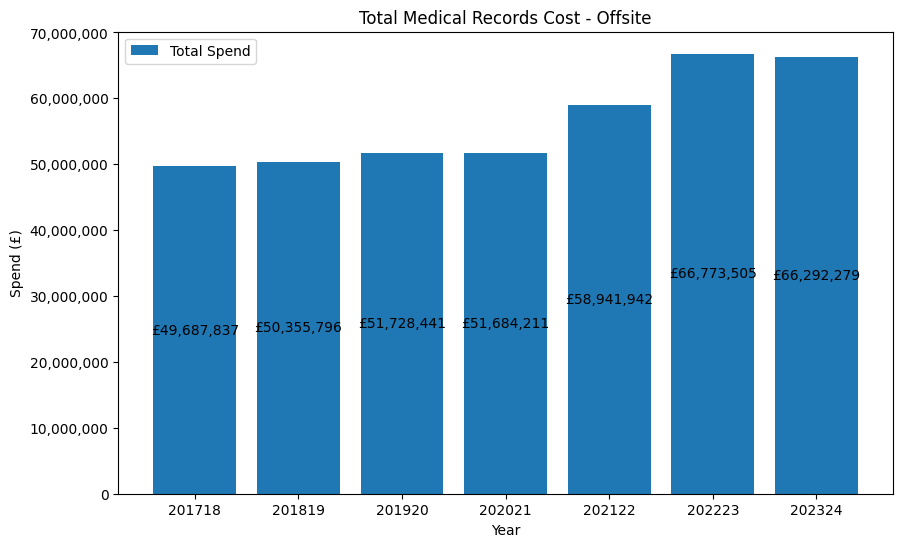

In [158]:
mrc_off_columns = [col for col in trust_df.columns if col.startswith('mrc_off')]
years = [col.split('_')[-1] for col in mrc_off_columns]
total_spend_by_year = trust_df[mrc_off_columns].sum()
draw_chart(years, {"Total Spend": total_spend_by_year}, f'Total Medical Records Cost - Offsite', "Year", "Spend (£)")

...and total storage.

In [159]:
trust_df = pd.read_csv('trust_mrc_sorted_formatted.csv')
mrc_on_columns = [col for col in trust_df.columns if col.startswith('mrc_on_')]
year_codes = [col[-6:] for col in mrc_on_columns]
for year_code in year_codes:
  trust_df['mrc_total_' + year_code] = trust_df['mrc_on_' + year_code] + trust_df['mrc_off_' + year_code]
trust_df.to_csv('trust_mrc_total_added.csv', index=False)

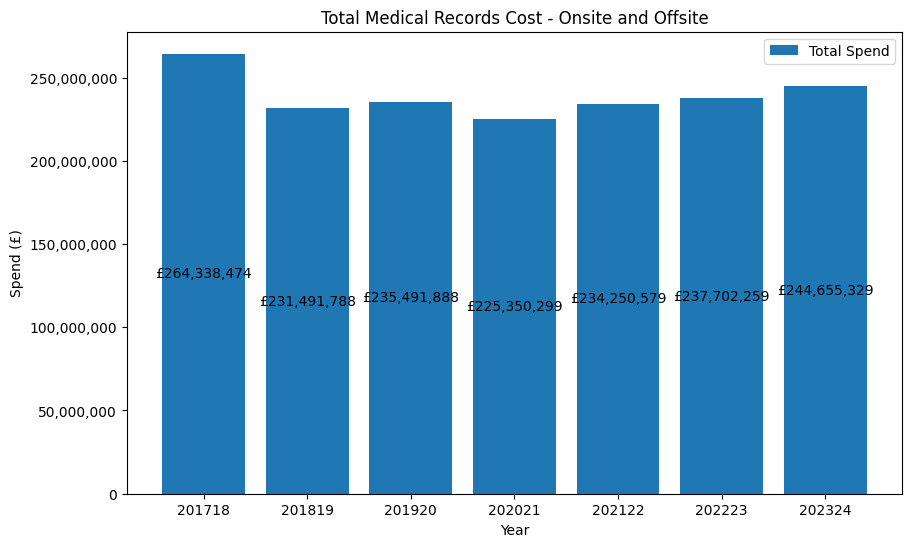

In [160]:
mrc_total_columns = [col for col in trust_df.columns if col.startswith('mrc_total')]
years = [col.split('_')[-1] for col in mrc_total_columns]
total_spend_by_year = trust_df[mrc_total_columns].sum()
draw_chart(years, {"Total Spend": total_spend_by_year}, f'Total Medical Records Cost - Onsite and Offsite', "Year", "Spend (£)")